In [320]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

###Activation Functions

In [321]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

def d_sigmoid(x):
  return (1 - sigmoid(x)) * sigmoid(x)

def tanh(x):
  return np.tanh(x)

def d_tanh(x):
    return 1 - np.square(np.tanh(x))

def relu(x):
  return np.where(np.asarray(x) > 0, x, 0)

def d_relu(x):
    return np.where(x <= 0, 0, 1)

def softmax(x):
    e_x = np.exp(x)
    return e_x/e_x.sum()

###Cost Function:

In [322]:
def cross_entropy_loss(y, y_hat, i):
  return -np.log(y_hat[y[i]][0])

In [323]:
def cost(y, y_hat, i):
  
  m = y.shape[0]
  c = (1/m) * np.sum(cross_entropy_loss(y, y_hat))
  c = np.squeeze(c) 

  return c

###Layer Class : parameters initialization for each layer

In [324]:
class Layer:

    activationFunc = {
        'tanh': (tanh, d_tanh),
        'sigmoid': (sigmoid, d_sigmoid),
        'relu' : (relu, d_relu),
        'softmax' : (softmax, None)
    }

    def __init__(self, inputs, neurons, activation):
        np.random.seed(33)
        self.W = np.random.randn(neurons, inputs)
        self.b = np.zeros((neurons, 1))
        self.act, self.d_act = self.activationFunc.get(activation)
        self.dW = 0
        self.db = 0

### Forward propagation

In [325]:
def forward_propagation(h, layers):
  m = len(layers)
  
  layers[0].a = np.dot(layers[0].W, h)
  layers[0].h = layers[0].act(layers[0].a)
  #print(layers[0].h.shape)
  
  for j in range(1, m-1):
    layers[j].a = np.dot(layers[j].W, layers[j-1].h)
    layers[j].h = layers[j].act(layers[j].a)
    #print(layers[j].h.shape)

  j+=1
  layers[j].a = np.dot(layers[j].W, layers[j-1].h)
  layers[j].h = softmax(layers[j].a)
  #print(layers[j].h.shape)

  return layers[m-1].h

###Backward_propagation

In [326]:
def backward_propagation(l, y_hat, layers, inp):
  
  #one-hot vector
  e_l = np.zeros((y_hat.shape[0], 1))
  e_l[l] = 1
  
  layers[len(layers)-1].da = -(e_l - y_hat)                 #gradient w.r.t activation of last layer (a_L)
  
  for j in range(len(layers)-1, 0, -1):
                        
    layers[j].dW += np.dot(layers[j].da, (layers[j-1].h).T)
    layers[j].db += layers[j].da

    layers[j-1].dh = np.dot((layers[j].W).T, layers[j].da)
    layers[j-1].da = np.multiply(layers[j-1].dh, layers[j-1].d_act(layers[j-1].a))

  layers[0].dW += np.dot(layers[0].da, inp.T)
  layers[0].db += layers[0].da

  return layers


###Gradient Descent

In [327]:
def update_params(learning_rate, layers, batch_size):
  for layer in layers:
    layer.W = layer.W - learning_rate * layer.dW/batch_size
    layer.b = layer.b - learning_rate * layer.db/batch_size

    layer.dW = 0
    layer.db = 0

###SGD / Batch Gradient Descent

In [328]:
def sgd(epochs, layers, learning_rate, x_train, y_train, batch_size):
    
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #stocastic gradient decent
        if (i+1) % batch_size == 0:
          update_params(learning_rate, layers, batch_size)

      costs.append(cost/m)

      print("Cost after epoch " + str(epoch) + " :", cost/m)

    return costs, layers

###Momentum Gradient descent

In [329]:
def mgd(epochs, layers, learning_rate, x_train, y_train, batch_size):

    gamma = 0.9
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #momentum gradient decent
        if (i+1) % batch_size == 0:
          for layer in layers:

            layer.update_W = gamma*layer.update_W + learning_rate*layer.dW/batch_size
            layer.update_b = gamma*layer.update_b + learning_rate*layer.dW/batch_size

            layer.W = layer.W - layer.update_W
            layer.b = layer.b - layer.update_b

            layer.dW = 0
            layer.db = 0

            layer.update_W = 0
            layer.update_b = 0


      costs.append(cost/m)

      print("Cost after epoch " + str(epoch) + " :", cost/m)

    return costs, layers

###Nesterov Gradient Descent

In [330]:
def nesterov(epochs, layers, learning_rate, x_train, y_train, batch_size):

    gamma = 0.9
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        #calculate W_lookaheads
        if (i+1) % batch_size == 0:
          for layer in layers:
            layer.W = layer.W - gamma * layer.update_W
            layer.b = layer.b - gamma * layer.update_b

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #nesterov gradient decent
        if (i+1) % batch_size == 0:
          for layer in layers:

            layer.update_W = gamma*layer.update_W + learning_rate*layer.dW/batch_size
            layer.update_b = gamma*layer.update_b + learning_rate*layer.dW/batch_size

            layer.W = layer.W - layer.update_W
            layer.b = layer.b - layer.update_b

            layer.dW = 0
            layer.db = 0

            layer.update_W = 0
            layer.update_b = 0

      costs.append(cost/m)
      print("Cost after epoch " + str(epoch) + " :", cost/m)
      
    return costs, layers  

###RMSProp

In [331]:
def rmsprop(epochs, layers, learning_rate, x_train, y_train, batch_size):

    epsilon, beta = 1e-8, 0.9
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #rmsprop gradient decent
        if (i+1) % batch_size == 0:
          for layer in layers:

            layer.update_W = beta*layer.update_W + (1-beta)*(layer.dW/batch_size)**2
            layer.update_b = beta*layer.update_b + (1-beta)*(layer.db/batch_size)**2

            layer.W = layer.W - (learning_rate / np.sqrt(layer.update_W + epsilon)) * (layer.dW/batch_size)
            layer.b = layer.b - (learning_rate / np.sqrt(layer.update_b + epsilon)) * (layer.db/batch_size)

            layer.dW = 0
            layer.db = 0

            layer.update_W = 0
            layer.update_b = 0


      costs.append(cost/m)

      print("Cost after epoch " + str(epoch) + " :", cost/m)

    return costs, layers

###Adam

In [332]:
def adam(epochs, layers, learning_rate, x_train, y_train, batch_size):

    epsilon, beta1, beta2 = 1e-8, 0.9, 0.99
    t = 0
    
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #adam gradient decent
        if (i+1) % batch_size == 0:
          t+=1

          for layer in layers:

            layer.m_W = beta1 * layer.m_W + (1-beta1)*layer.dW/batch_size
            layer.m_b = beta1 * layer.m_b + (1-beta1)*layer.db/batch_size

            layer.v_W = beta2 * layer.v_W + (1-beta2)*((layer.dW/batch_size))**2
            layer.v_b = beta2 * layer.v_b + (1-beta2)*((layer.db/batch_size))**2

            layer.m_W_hat = layer.m_W/(1-math.pow(beta1, t))
            layer.m_b_hat = layer.m_b/(1-math.pow(beta1, t))

            layer.v_W_hat = layer.v_W/(1-math.pow(beta2, t))
            layer.v_b_hat = layer.v_b/(1-math.pow(beta2, t))

            layer.W = layer.W - (learning_rate/np.sqrt(layer.v_W_hat + epsilon))*layer.m_W_hat
            layer.b = layer.b - (learning_rate/np.sqrt(layer.v_b_hat + epsilon))*layer.m_b_hat

            layer.dW = 0
            layer.db = 0

            layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0


      costs.append(cost/m)

      print("Cost after epoch " + str(epoch) + " :", cost/m)

    return costs, layers

###NAdam

In [333]:
def nadam(epochs, layers, learning_rate, x_train, y_train, batch_size):

    epsilon, beta1, beta2 = 1e-8, 0.9, 0.99
    gamma = 0.9
    t = 0
    
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        #calculate W_lookaheads
        if (i+1) % batch_size == 0:
          for layer in layers:
            layer.W = layer.W - gamma * layer.m_W
            layer.b = layer.b - gamma * layer.m_b
        
        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #adam gradient decent
        if (i+1) % batch_size == 0:
          t+=1

          for layer in layers:

            layer.m_W = beta1 * layer.m_W + (1-beta1)*layer.dW/batch_size
            layer.m_b = beta1 * layer.m_b + (1-beta1)*layer.db/batch_size

            layer.v_W = beta2 * layer.v_W + (1-beta2)*((layer.dW/batch_size))**2
            layer.v_b = beta2 * layer.v_b + (1-beta2)*((layer.db/batch_size))**2

            layer.m_W_hat = layer.m_W/(1-math.pow(beta1, t))
            layer.m_b_hat = layer.m_b/(1-math.pow(beta1, t))

            layer.v_W_hat = layer.v_W/(1-math.pow(beta2, t))
            layer.v_b_hat = layer.v_b/(1-math.pow(beta2, t))

            layer.m_dash_W = beta1 * layer.m_W_hat + (1-beta1)*layer.dW/batch_size
            layer.m_dash_b = beta1 * layer.m_b_hat + (1-beta1)*layer.db/batch_size

            layer.W = layer.W - (learning_rate/np.sqrt(layer.v_W_hat + epsilon))*layer.m_dash_W
            layer.b = layer.b - (learning_rate/np.sqrt(layer.v_b_hat + epsilon))*layer.m_dash_b

            layer.dW = 0
            layer.db = 0

            layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0


      costs.append(cost/m)

      print("Cost after epoch " + str(epoch) + " :", cost/m)

    return costs, layers

###Putting all togather:

###Function to Train Model

In [334]:
def model_train(optimizer, epochs, learning_rate, x_train, y_train, activation, h_layers, neurons, batch_size):

  layers= [Layer(x_train.shape[1], neurons, activation)]

  for _ in range(0, h_layers-1):
    layers.append(Layer(neurons, neurons, activation))
  layers.append(Layer(neurons, 10, 'softmax'))
  
  if optimizer == "sgd":
    return sgd(epochs, layers, learning_rate, x_train, y_train, batch_size)
  elif optimizer == "mgd":
    return mgd(epochs, layers, learning_rate, x_train, y_train, batch_size)
  elif optimizer == "nesterov":
    return nesterov(epochs, layers, learning_rate, x_train, y_train, batch_size)
  elif optimizer == "rmsprop":
    return rmsprop(epochs, layers, learning_rate, x_train, y_train, batch_size)
  elif optimizer == "adam":
    return adam(epochs, layers, learning_rate, x_train, y_train, batch_size)
  elif optimizer == "nadam":
    return nadam(epochs, layers, learning_rate, x_train, y_train, batch_size)
  else:
    print("No optimization algorithm named "+optimizer+" found")
    return "Error", "Error"

###Function to Predict

In [335]:
def predict(input, y):
  prediction = forward_propagation(input, layers)
  prediction = prediction.argmax(axis=0)
  accuracy =  np.sum(prediction == y)/y.shape[0]
  return prediction, accuracy

###Import dataset and putting in appropriate format

In [336]:
from keras.datasets import fashion_mnist
(x_train_org, y_train_org), (x_test_org, y_test_org) = fashion_mnist.load_data()

In [337]:
print("x_train shape: ", x_train_org.shape)
print("y_train shape: ", y_train_org.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)


In [338]:
'''first_image = x_train_org[0]
#first_image = np.array(first_image, dtype='float')
#pixels = first_image.reshape((28, 28))
i = True
while(i):
  if
  plt.imshow(x_train_org[i], cmap='gray')
  plt.title("class: "+ str(y_train_org[i]))
  plt.show()'''

'first_image = x_train_org[0]\n#first_image = np.array(first_image, dtype=\'float\')\n#pixels = first_image.reshape((28, 28))\ni = True\nwhile(i):\n  if\n  plt.imshow(x_train_org[i], cmap=\'gray\')\n  plt.title("class: "+ str(y_train_org[i]))\n  plt.show()'

####Flattening the data

In [339]:
x_train_temp = x_train_org.reshape(x_train_org.shape[0], -1)
y_train_temp = y_train_org
x_test = x_test_org.reshape(x_test_org.shape[0], -1)
y_test = y_test_org

####Splliting dataset into training and validation

In [340]:
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.1, random_state=33)

In [341]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_val shape: ", x_val.shape)
print("y_val shape: ", y_val.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (54000, 784)
y_train shape:  (54000,)
x_val shape:  (6000, 784)
y_val shape:  (6000,)
x_test shape:  (10000, 784)
y_test shape:  (10000,)


###Train Model

In [342]:
optimizer = "nadam"
epochs = 10
learning_rate = 0.001
activation = 'tanh'
h_layers = 5
neurons = 64
batch_size = 16

costs, layers = model_train(optimizer, epochs, learning_rate, x_train, y_train, activation, h_layers, neurons, batch_size)

Cost after epoch 0 : 3.441106471573012
Cost after epoch 1 : 1.486003595629301
Cost after epoch 2 : 1.264526580205672
Cost after epoch 3 : 1.158255766414733
Cost after epoch 4 : 1.102467952098729
Cost after epoch 5 : 1.0276968541390494
Cost after epoch 6 : 1.0119884944787592
Cost after epoch 7 : 1.0084171028801403
Cost after epoch 8 : 0.9957740960703261
Cost after epoch 9 : 0.9881838511667896


###Cost per epoch graph

[3.441106471573012, 1.486003595629301, 1.264526580205672, 1.158255766414733, 1.102467952098729, 1.0276968541390494, 1.0119884944787592, 1.0084171028801403, 0.9957740960703261, 0.9881838511667896]


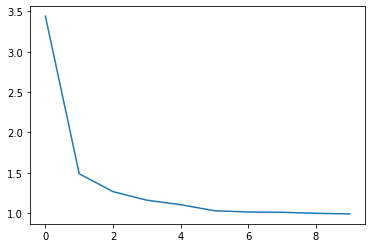

In [343]:
plt.plot(range(epochs), costs)
print(costs)

###Predictions and accuracy using validation data and test data

In [344]:
output_val, accuracy_val = predict(x_val.T, y_val)
output_test, accuracy_test = predict(x_test.T, y_test)
print("Validation accuracy: ", accuracy_val)
print("Test accuracy: ", accuracy_test)

Validation accuracy:  0.6718333333333333
Test accuracy:  0.6686
